# Izhikevich Neuron Model

Model is described using two variables v and u.

$${v}' = 0.04{v}^{2} -5{v} + 140 - {u} + {I} $$


$${u}' = {a} ({b}{v} - {u} )  $$

$$ If \  {v} > {30mV} $$
$$ Then \ {v} = {c} \ \ and \ \ {u} = {u} + {d} $$

Here we are taking v as var1 and u as var2 in the code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [2]:
def get_next_state(prev_state,model_params,dt):
    curr_state = np.zeros(2)
    if prev_state[0] > 30:
        curr_state[0] = model_params[2]
        curr_state[1] = prev_state[1] + model_params[3]
    else:
        curr_state[0] = prev_state[0]+ dt*(0.04*prev_state[0]**2 + 5*prev_state[0] + 140 - prev_state[1] + model_params[4])
        curr_state[1] = prev_state[1]+ dt*(model_params[0]*(model_params[1]*prev_state[0] - prev_state[1]))
    return curr_state

In [3]:
# get all values of var2 for the given range of var1 when d (var1)/dt = 0
def get_var1_nullcline(model_params,var1_range):
    var1_nullcline = np.zeros(len(var1_range))
    for i in range(len(var1_range)):
        var1_nullcline[i] = 0.04*var1_range[i]**2 + 5*var1_range[i] + 140 - model_params[4]
    return var1_nullcline

In [4]:
# get all values of var2 for the given range of var1 when d (var2)/dt = 0
def get_var2_nullcline(model_params,var1_range):
    var2_nullcline = np.zeros(len(var1_range))
    for i in range(len(var1_range)):
        var2_nullcline[i] = model_params[1]*var1_range[i]
    return var2_nullcline

In [5]:
def find_freq(states):
    var1=states[:,0]
    peaks=find_peaks(var1)[0]

    for i in peaks:
        if(var1[i]<0):
            peaks=np.delete(peaks,np.where(peaks==i))
    ## calc rate
    dt=100
    frarr=[]
    for i in range(0,1000,dt):
       fr= ((i < peaks) & (peaks < i+dt)).sum()
       frarr.append(fr/dt)
    #print(frarr)
    return frarr

In [6]:
def get_state(states,params,dt):
    for i in range(1,states.shape[0]):
        states[i,:] = get_next_state(states[i-1,:],params,dt)
    return states    

In [7]:
def plot_all(states,params,range1,range2,tstop,dt,freq,str):
    # Create a figure with two pairs of axes for phase plot and time plot
    fig = plt.figure(figsize = [15,8])
    phax = fig.add_axes([.075,.1,.4,.8])
    timax = fig.add_axes([.55,.1,.4,.8])
    fig2,freqax = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))
    # freqax = fig2.add_subplot(111)
    # freqax2=fig2.add_subplot(121)

    fig.suptitle(f'Izhikevich Neuron Model for {str} with a ={params[0]},b={params[1]},c={params[2]}, d= {params[3]},I={params[4]}',fontsize=20)
    # Display nullcline and trajectory of neuron in phase space
    phax.plot(range1,get_var1_nullcline(params,range1),color='darkorange',linewidth=3,label='v-nullcline')
    phax.plot(range1,get_var2_nullcline(params,range1),color='darkgreen',linewidth=3,label='u-nullcline')
    phax.plot(states[:,0],states[:,1],color='slateblue',linewidth=3,label='neuron trajectory')
    
    # Display trajectory of var1 and var2 with time
    timax.plot(np.arange(0,tstop,dt),states[:,0],color='slateblue',linewidth=3,label='v')
    timax.plot(np.arange(0,tstop,dt),states[:,1],color='maroon',linewidth=3,label='u')
    
   
    freqax[0].plot(np.arange(0,1000,100),freq,color='maroon',marker="*")
    freqax[0].set_xlabel("")
    freqax[0].set_ylabel("Firing Rate (frequency/dt) ")
    freqax[1].plot(np.arange(0,tstop,dt),states[:,0],color='slateblue')
    freqax[1].set_ylabel("Voltage")
    freqax[1].set_xlabel("Time in seconds ")
    plt.tight_layout()
    
    # Set legends and other graph parameters
    phax.set_xlabel('v')
    phax.set_ylabel('u')
    timax.set_xlabel('Time')
    timax.set_ylabel('v/u')
    phax.set_xlim(min(range1),max(range1))
    phax.set_ylim(min(range2),max(range2))
    phax.legend(loc=0)
    timax.legend(loc=0)
    plt.show()


In [8]:
tstop = 100 # time to simulate
dt = 0.1 #ms discrete time step
#define range of var1 and var2 to display
range1 = np.arange(-100,50,1)
range2 = np.arange(-50,50,1)
states = np.zeros((int(tstop/dt),2)) # each state is a pair of (v,u)

In [9]:
# Initialise model parameters 
# a,b,c,d,I
params_rs=[0.02,0.2,-65,8,10]  # regular spiking
params_ib=[0.02,0.2,-55,4,10]   # intrinsically bursting
params_ch=[0.02,0.2,-50,2,10]   # chattering
params_fs=[0.1,0.2,-65,2,10]    # fast spiking
params_tc=[0.02,0.25,-65,0.05,10]   # thalamo-cortical
params_rz=[0.1,0.27,-65,2,10]   # resonator
params_lts=[0.02,0.25,-65,2,10] # low-threshold spiking

### Excitatory cortical cells are divided into regular spiking, intrinsically bursting and chattering cells.
### Inhibitory cortical cells are divided into fast spiking, low-threshold spiking
Other cells which provide large input to cortex are thalamo-cortical and resonator.

## Regular spiking 
RS (regular spiking) neurons are the most typical neurons in the cortex. When given prolonged stimulus (injected current) the neurons fire a few spikes with short inter-spike period and then the period increases. This is called the spike frequency adaptation. If we increase injected current the inter-spike frequency increases, but it is not becoming too fast because of large spike-after hyperpolarizations.

Here c= -65 correspond to deep voltage reset and d= 8 to large after-spike jump of u.


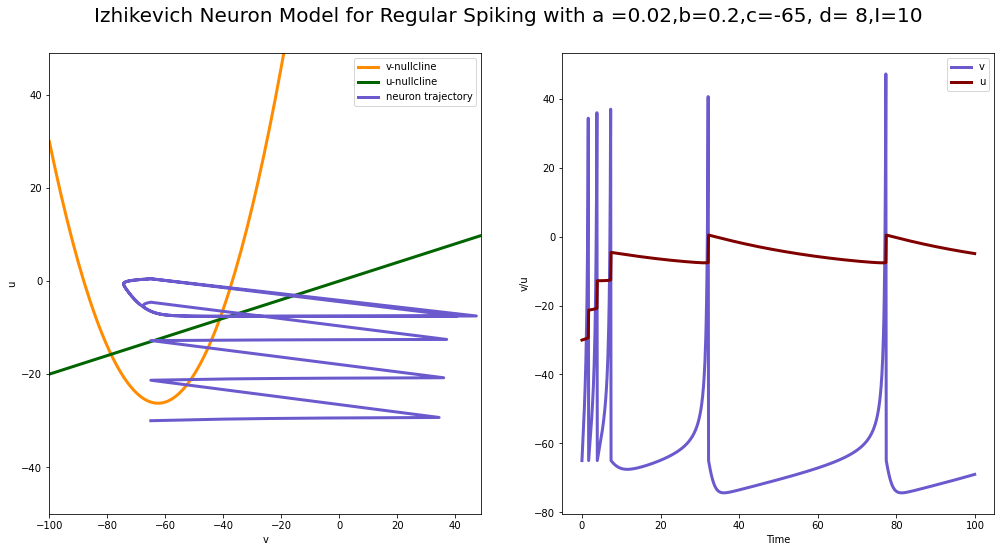

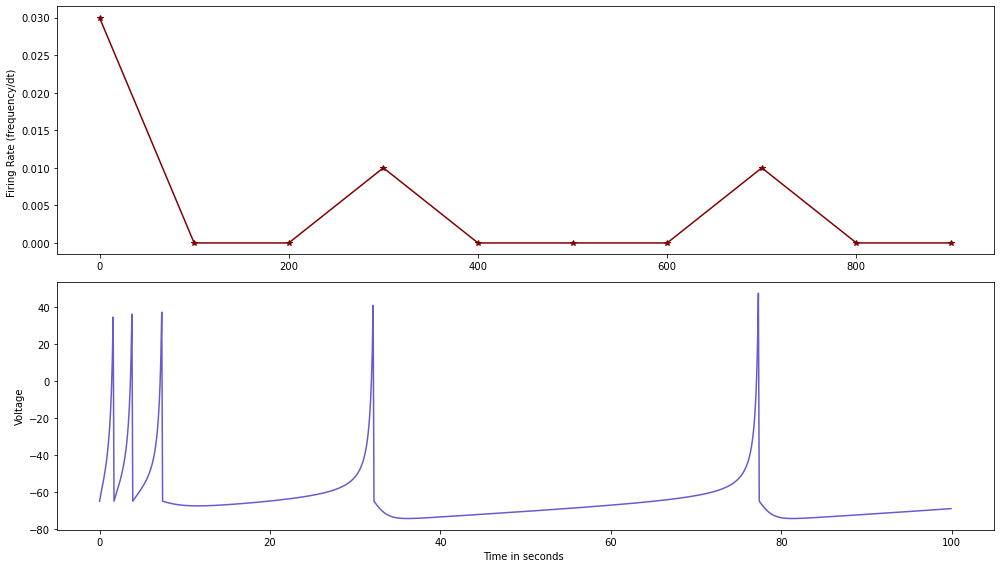

In [10]:
states[0] = [-65, -30]
states = get_state(states,params_rs,dt)
freq=find_freq(states)
plot_all(states,params_rs,range1,range2,tstop,dt,freq,"Regular Spiking")

## Intrinsically Bursting
IB (intrinsically bursting) neurons fire a burst of spikes followed by repetitive single spikes. 

Here c = -55 corresponds to high voltage reset and d= 4 to large after-spike jump of u. During the initial burst, variable u builds up, then switches to spiking from bursting.

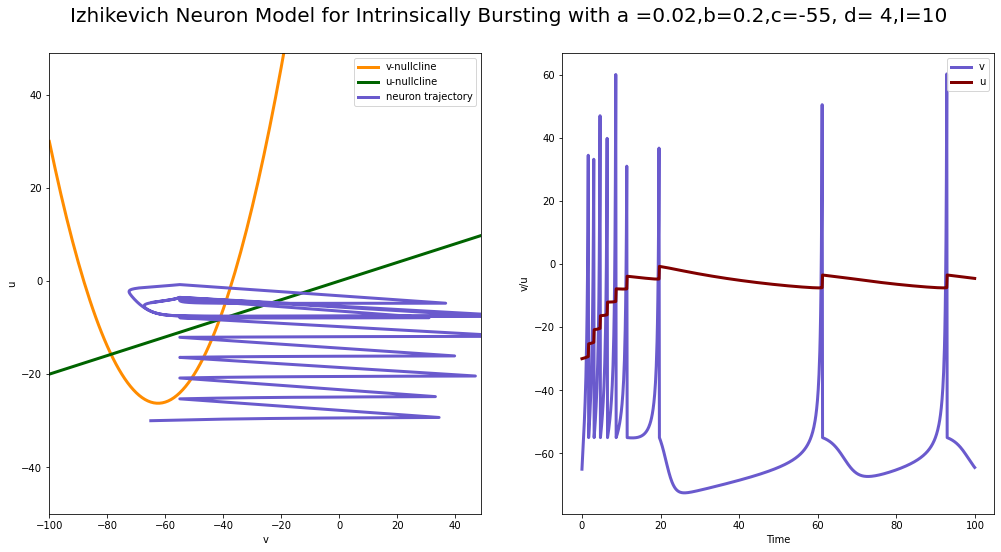

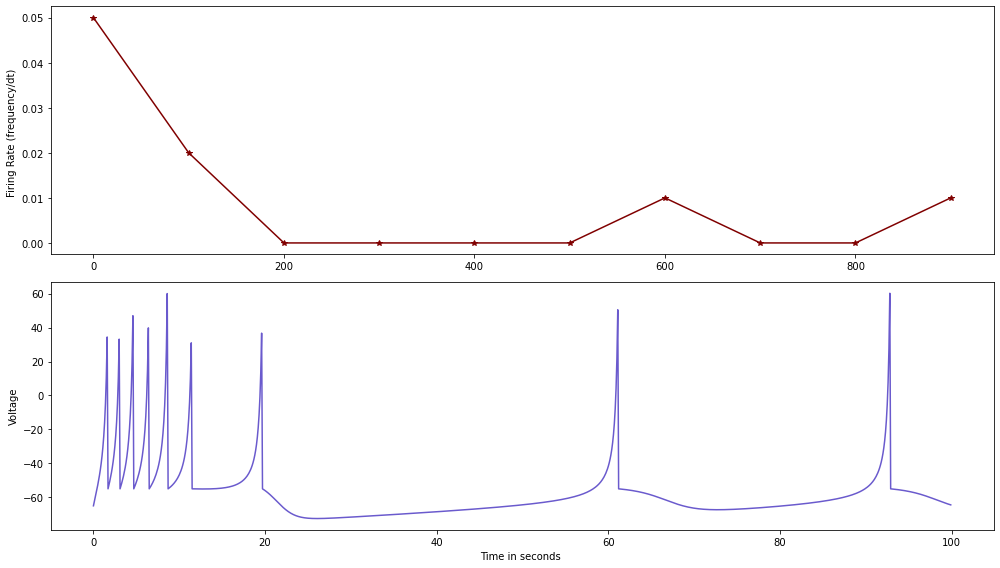

In [11]:
states[0] = [-65, -30]
states = get_state(states,params_ib,dt)
freq=find_freq(states)
plot_all(states,params_ib,range1,range2,tstop,dt,freq,"Intrinsically Bursting")

## Chattering
Chattering neurons fire typical bursts of closely spaced spikes. The inter-burst frequency can be as high as 40 Hz.

Here c = -50 corresponds to very high voltage reset and d=2 to moderate after-spike jump of u.

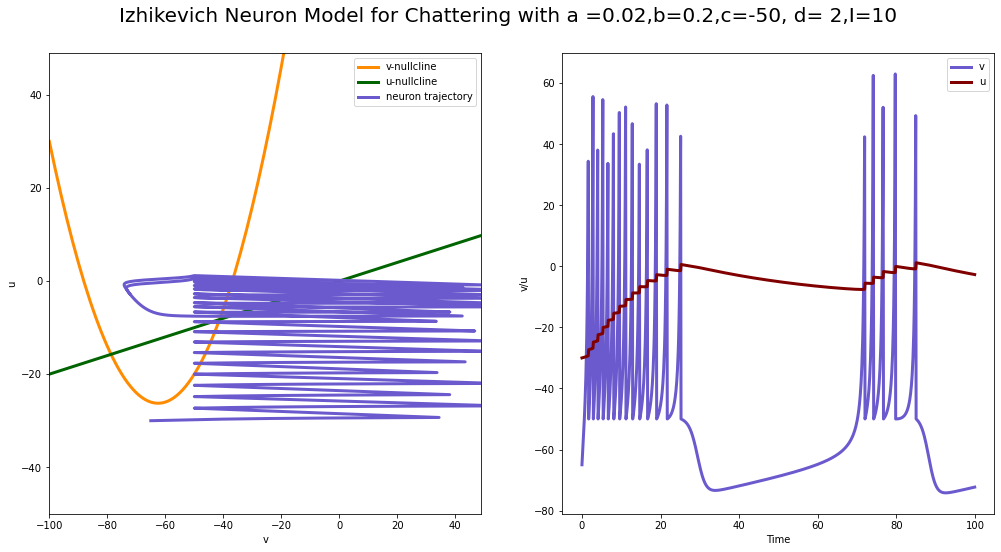

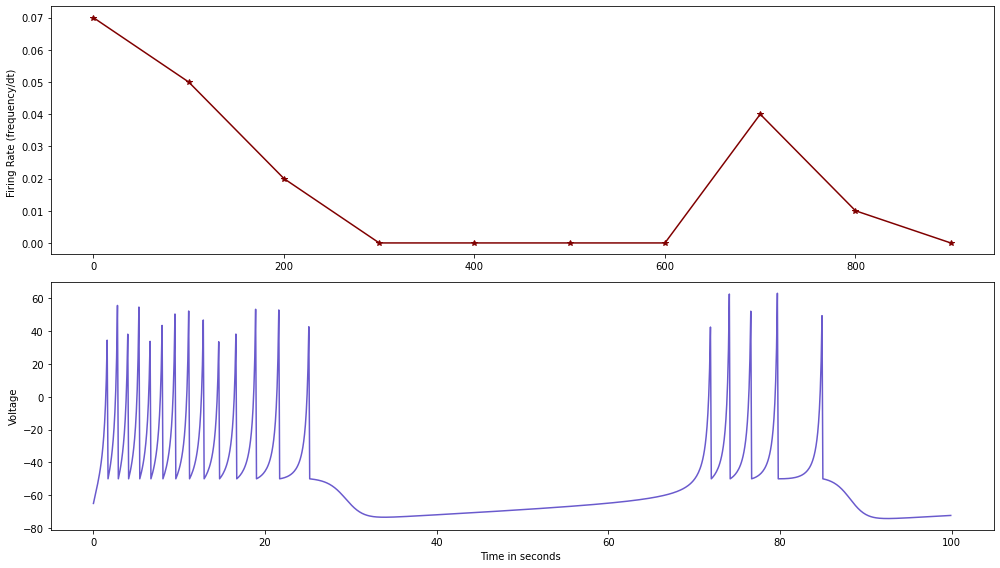

In [12]:
states[0] = [-65, -30]
states = get_state(states,params_ch,dt)
freq=find_freq(states)
plot_all(states,params_ch,range1,range2,tstop,dt,freq,"Chattering")

## Fast Spiking
FS (fast spiking) neurons typically fire periodic trains of action potentials with extremely high frequency practically without any adaptation (slowing down).

Here a=0.1 corresponds to fast recovery.

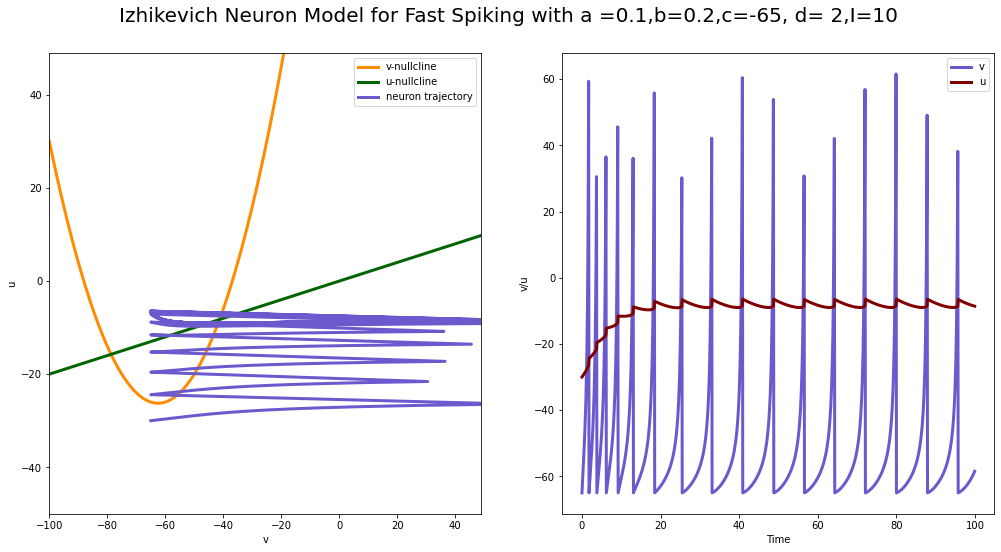

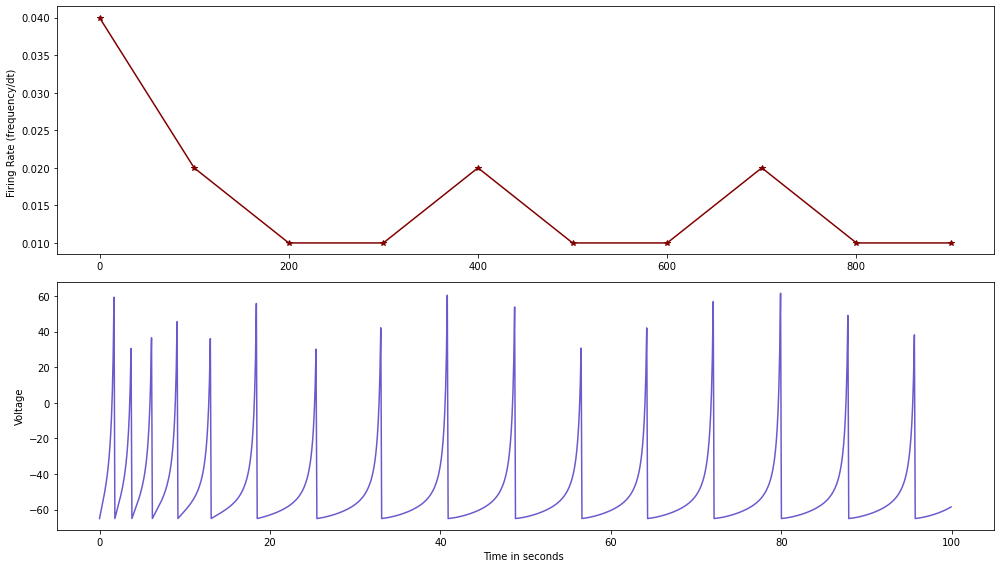

In [13]:
states[0] = [-65, -30]
states = get_state(states,params_fs,dt)
freq=find_freq(states)
plot_all(states,params_fs,range1,range2,tstop,dt,freq,"Fast Spiking")

## Thalamo-cortical
TC (thalamo-cortical) neurons have two different firing patterns. When at resting potential ( v is around -60 mV) and then depolarized, they exhibit tonic firing. However, if membrane potential is hyperpolarized ( v is around -90 mV), the neurons fire a rebound burst of action potentials.

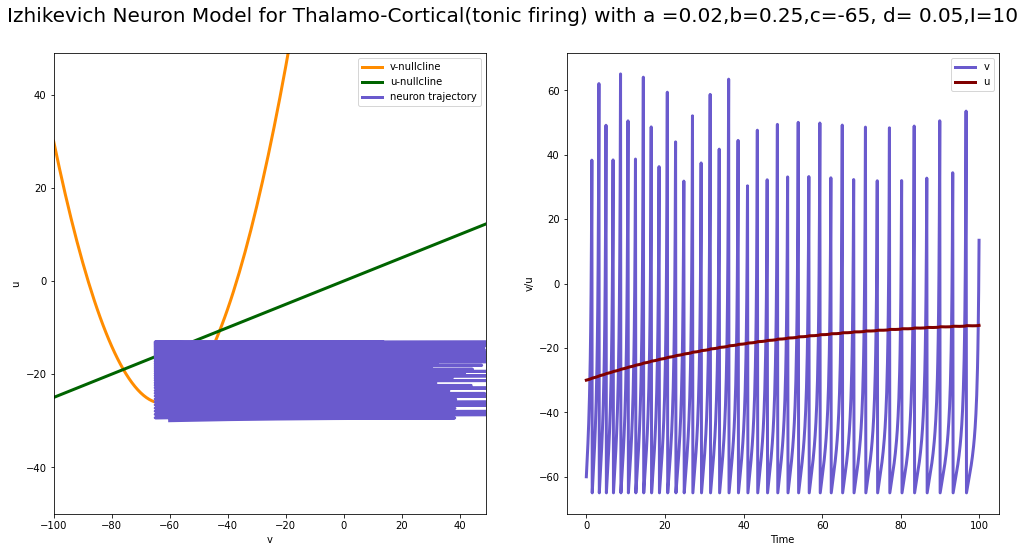

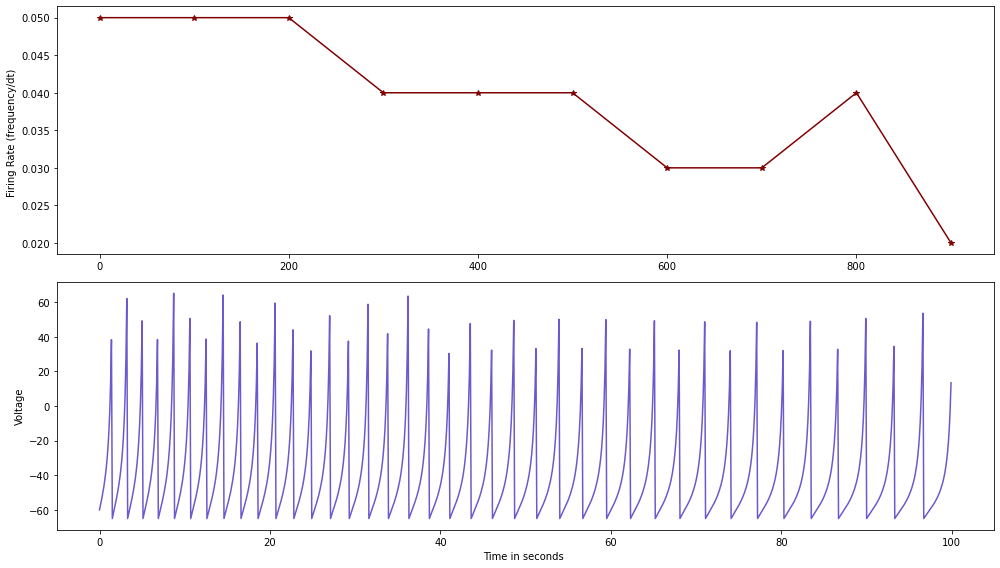

In [14]:
states[0] = [-60, -30]
states = get_state(states,params_tc,dt)
freq=find_freq(states)
plot_all(states,params_tc,range1,range2,tstop,dt,freq,"Thalamo-Cortical(tonic firing)")

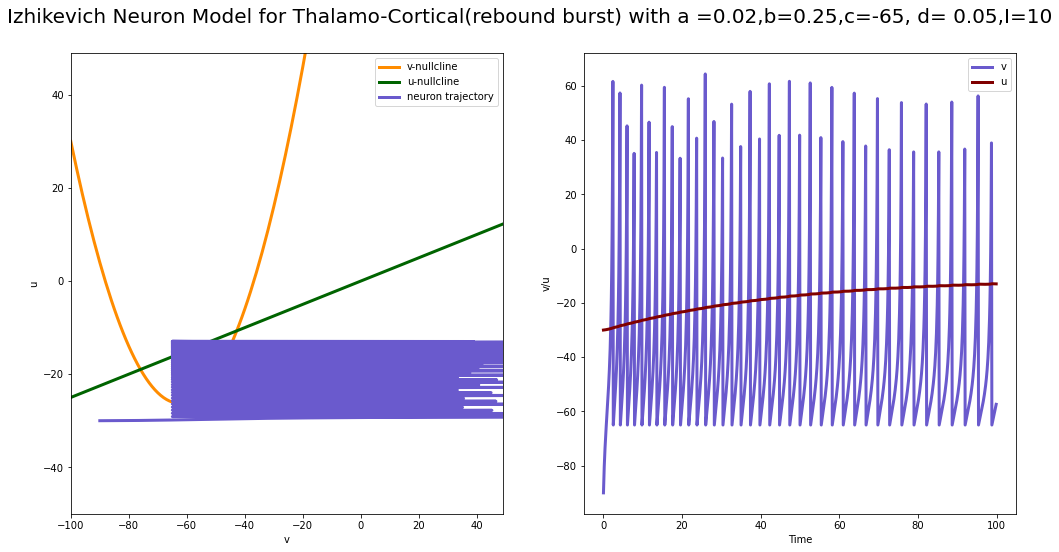

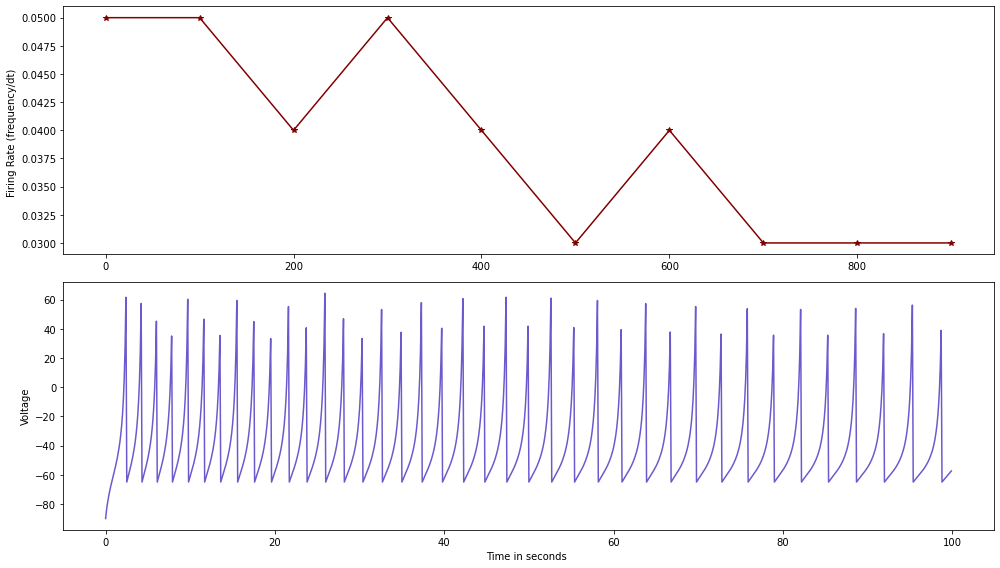

In [15]:
states[0] = [-90, -30]
states = get_state(states,params_tc,dt)
freq=find_freq(states)
plot_all(states,params_tc,range1,range2,tstop,dt,freq,"Thalamo-Cortical(rebound burst)")

## Resonator 
RZ (resonator) neurons have damped or sustained subthreshold oscillations. They resonate to rhythmic inputs having appropriate frequency.

Here, this behavior corresponds to a=0.1 and b= 0.27.

Here we can observe that there is a bistability of resting and repetitive spikings tates: The neuron can be switched between the states by an appropriately timed short stimuli.

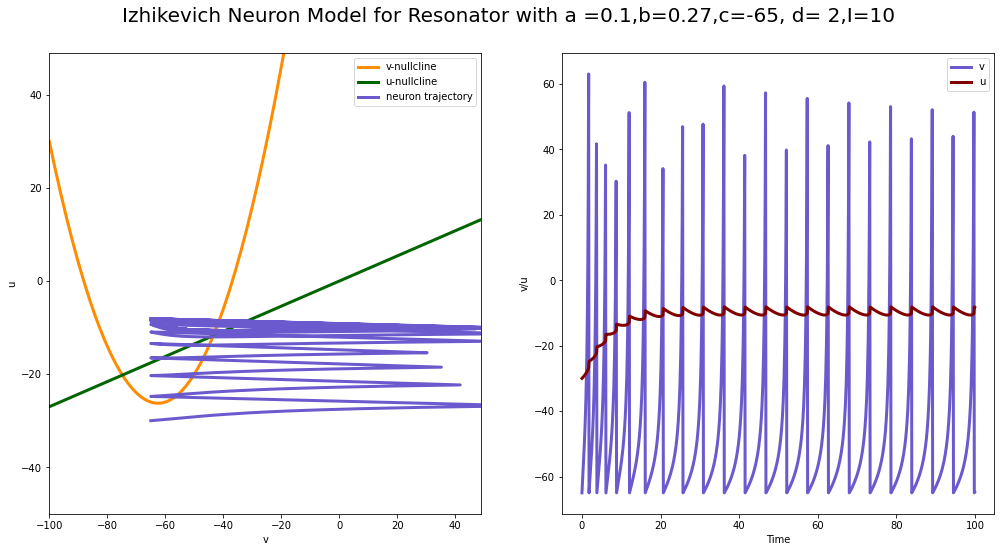

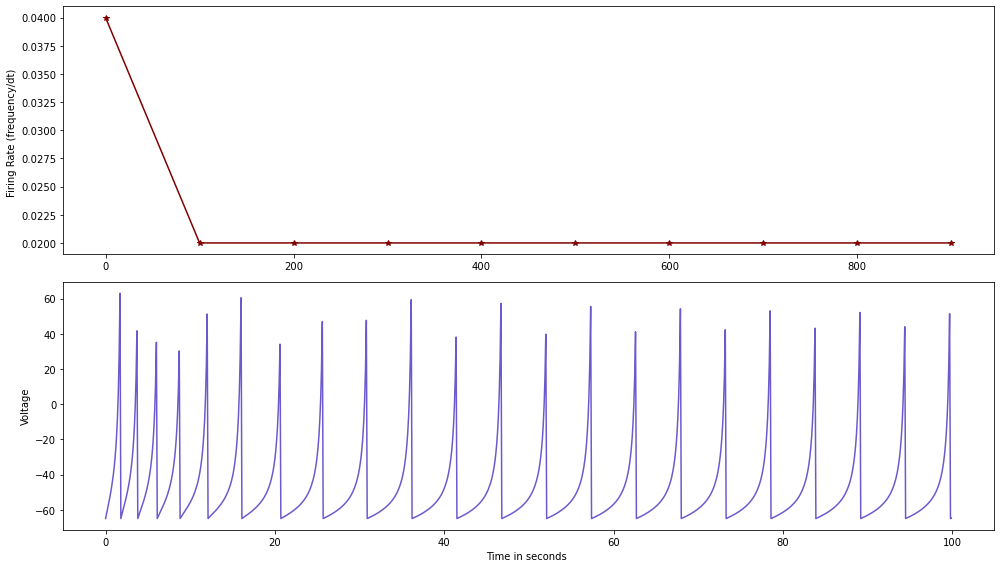

In [16]:
states[0] = [-65, -30]
states = get_state(states,params_rz,dt)
freq=find_freq(states)
plot_all(states,params_rz,range1,range2,tstop,dt,freq,"Resonator")

## Low Threshold Spiking(LTS)
LTS (low-threshold spiking) neurons can fire high-frequency trains of action potentials, but with a noticeable spike frequency adaptation. 

These neurons have low firing thresholds, which is accounted for by b=0.25 in the model. 

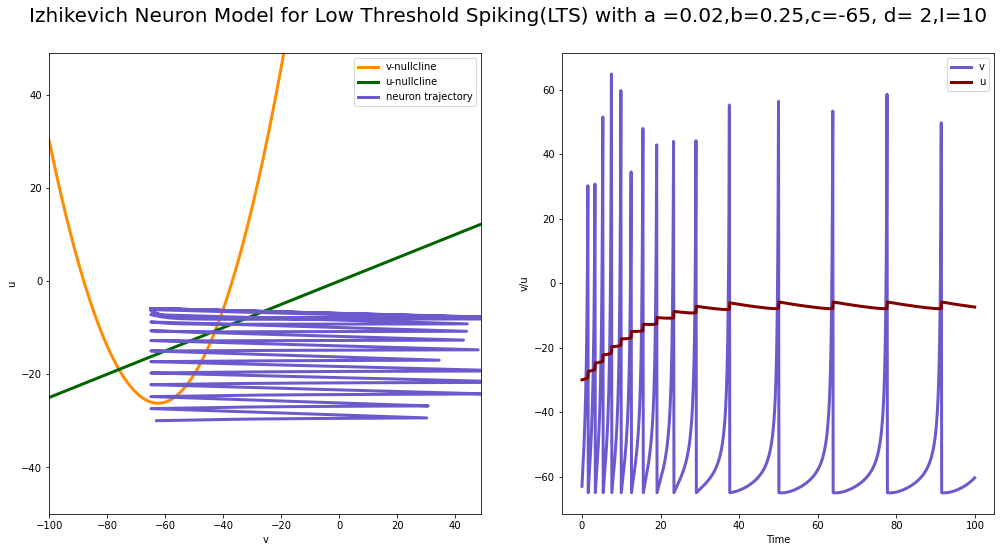

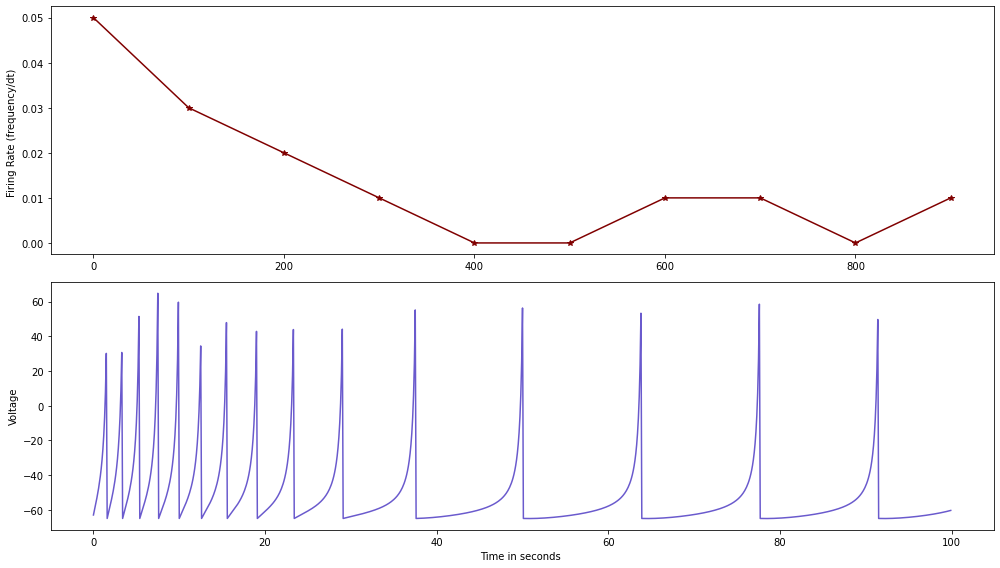

In [17]:
states[0] = [-63, -30]
states = get_state(states,params_lts,dt)
freq=find_freq(states)
plot_all(states,params_lts,range1,range2,tstop,dt,freq,"Low Threshold Spiking(LTS)")

## Some Other patterns
Here we will see All or none spiking, excitation block spiking and refractory period spiking.

In [18]:
params_U = [0.1,0.26,-60,5,10]
params_V = [0.02,27.65,-55,-100,10]
params_W = [0.1,0.25,-60,5,5]

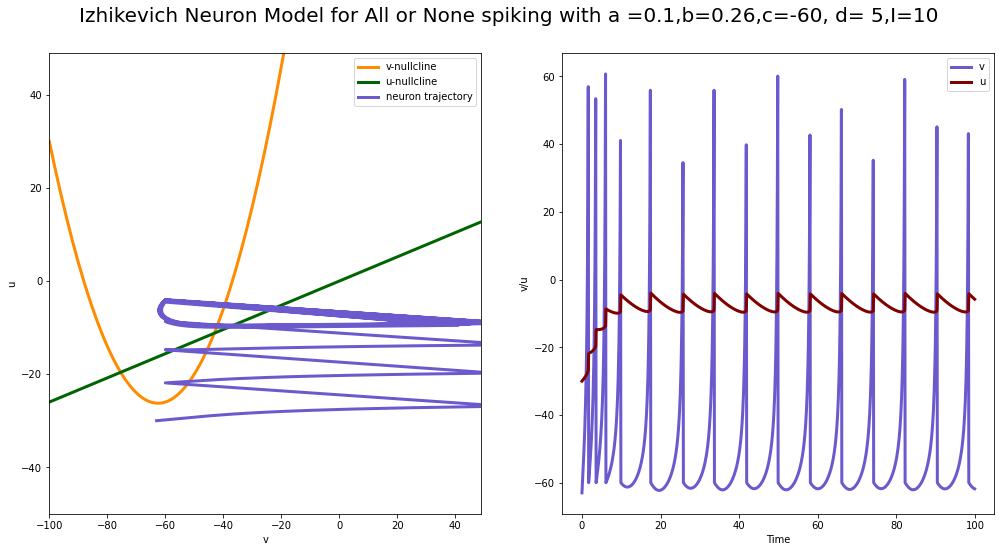

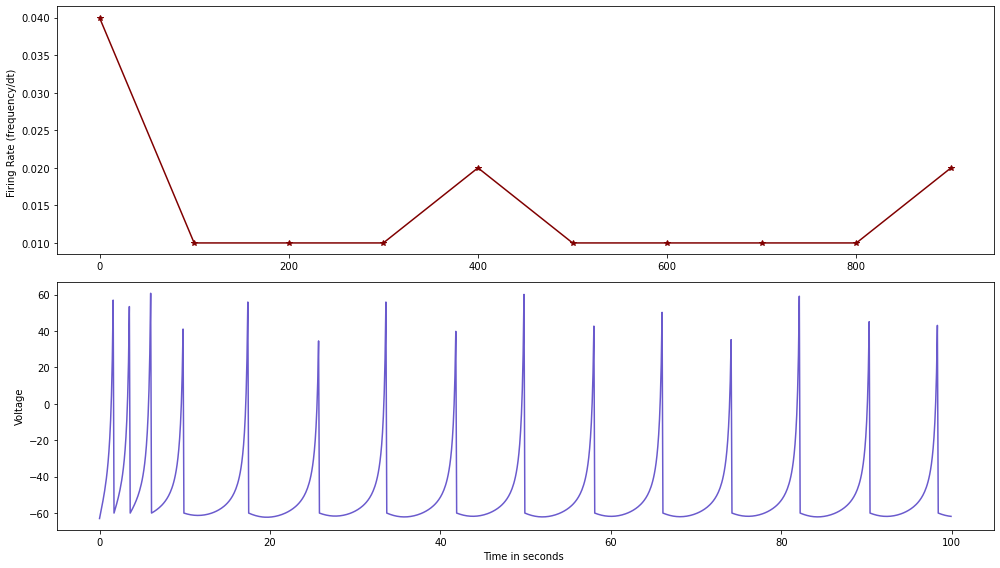

In [19]:
states[0] = [-63, -30]
states = get_state(states,params_U,dt)
freq=find_freq(states)
plot_all(states,params_U,range1,range2,tstop,dt,freq,"All or None spiking")

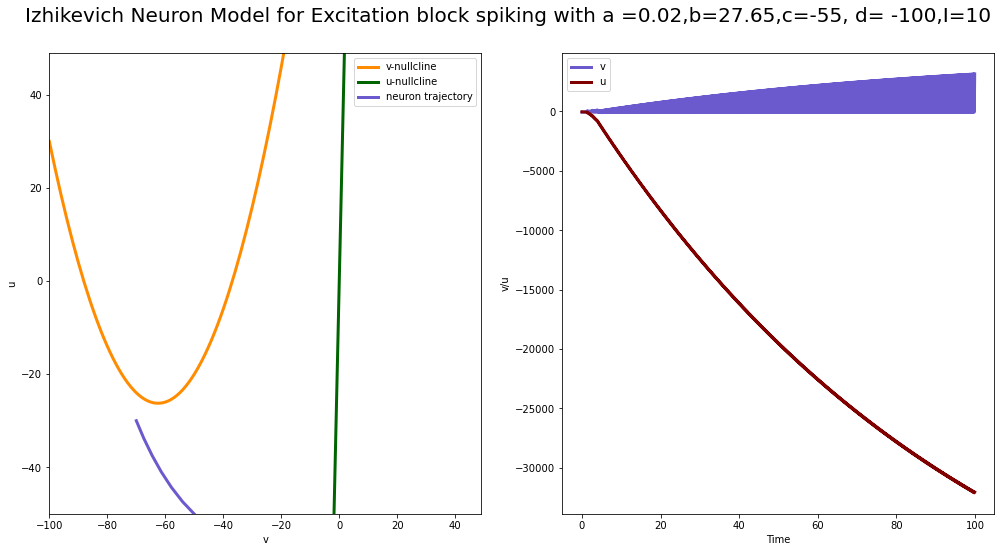

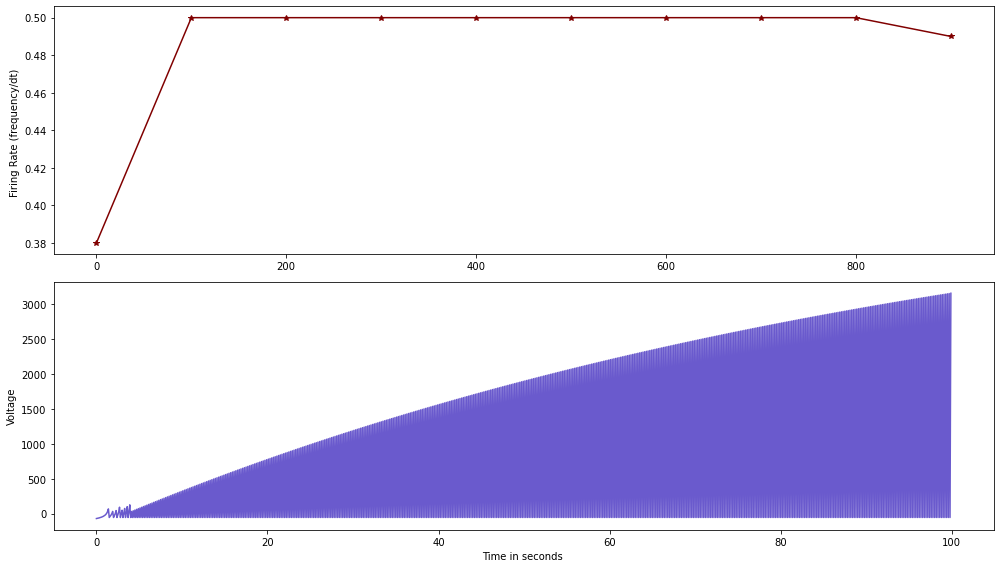

In [20]:
states[0] = [-70, -30]
states = get_state(states,params_V,dt)
freq=find_freq(states)
plot_all(states,params_V,range1,range2,tstop,dt,freq,"Excitation block spiking")

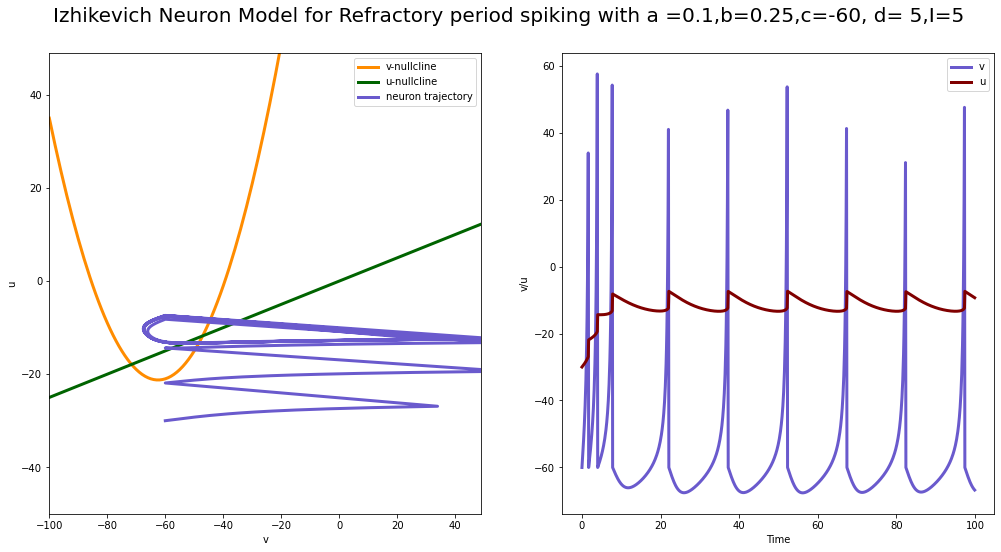

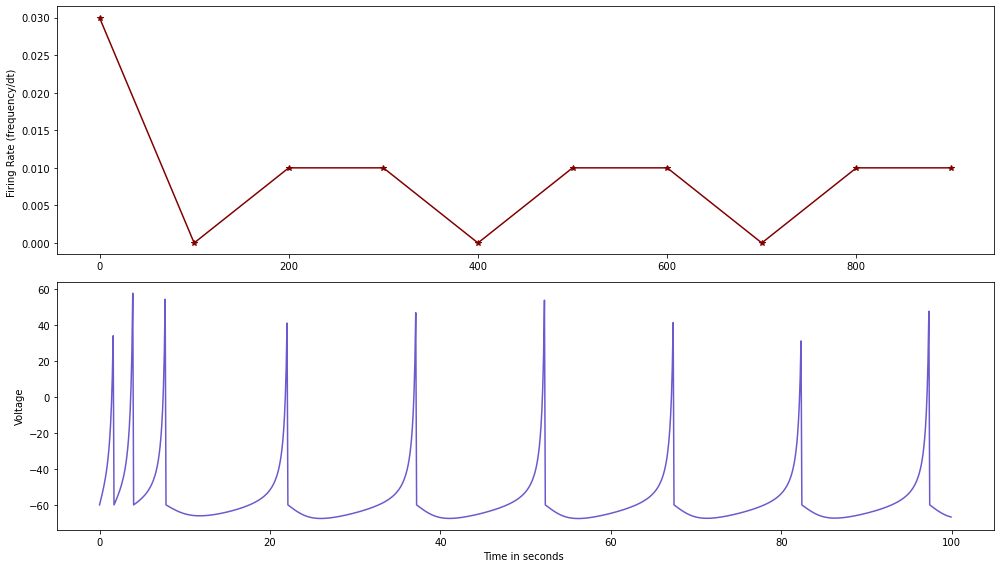

In [21]:
states[0] = [-60, -30]
states = get_state(states,params_W,dt)
freq=find_freq(states)
plot_all(states,params_W,range1,range2,tstop,dt,freq,"Refractory period spiking")

## Conclusion
In this model v represents the membrane potential of the neuron and u represents a membrane recovery variable, which accounts for the activation of K+ ionic currents and inactivation of Na+ ionic currents, and it provides negative feedback to v. So v can be thought of as V in HH model and u can be thought of as n in HH model (not exactly but just for intution).

### Different parameters represent various properties
> a : It reprents time scale of the recovery variable u. Smaller values tend to result in slower recovery and vice versa

> b : It represnts sensitivity of the recovery variable u to the subthreshold fluctuations of the membrane potential v.

> c : It represnts after-spike reset value of the membrane potential v caused by the fast high-threshold K+ conductances.

> d : It represnts after-spike reset of the recovery variable u caused by slow high-threshold K+ and Na+ conductances.

> I : It represents the injected current and more the value of I more the probablity of firing and for a very large I the inter-spike frequency will keep on increase.

By tuning the variables we can obtain wide range of different type of neurons, it's a very simple model but can be used in various places. Apart from what is shown in above graphs it can be used to represent phasic spiking, phasic bursting, integrator, DAP, threshold variability and many more.